In [19]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [21]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [10]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [11]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

start_dt = "2016-08-01"
end_dt = "2017-08-07"

temp_data = calc_temps(start_dt, end_dt)[0]
temp_data

(58.0, 74.69900389779126, 87.0)

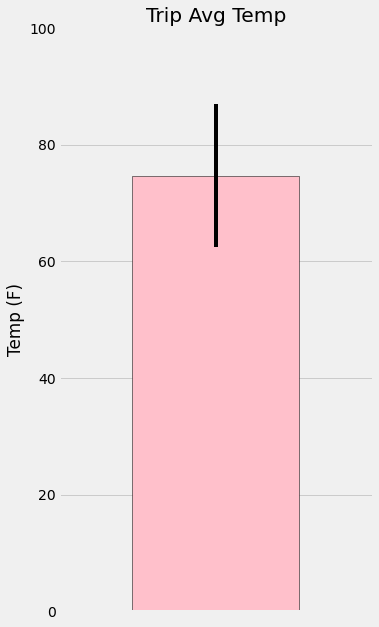

In [12]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x = [0]
y = [temp_data[1]]
yerr = [(temp_data[2]- temp_data[1])]

plt.figure(figsize= (5,10))
plt.bar(x,y, color="pink", edgecolor="black", yerr=yerr)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xlim(-0.75, 0.75)
plt.ylim(0,100)
plt.tick_params(axis="x", which="both",bottom=False,top=False,labelbottom=False)

plt.grid(which="major", axis="x", linestyle='')
plt.grid(which="major", axis="y", linestyle="-")

plt.savefig("/Users/tanishacooper/code/sqlalchemy-challenge/Images/trip_avg_temp.png", bbox_inches = "tight")
plt.show()

### Daily Rainfall Average

In [17]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel_query = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,\
             func.sum(Measurement.prcp)]

total_rainfall_res = session.query(*sel_query).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= start_dt).\
    filter(Measurement.date <= end_dt).\
    order_by(func.sum(Measurement.prcp).desc()).all()

stations_rainfall  = pd.DataFrame(total_rainfall_res, columns=["Station", "Name", "Latitude",\
                                                               "Longitude", "Elevation",\
                                                           "Prcp Total"])
plt.show()
plt.savefig("/Users/tanishacooper/code/sqlalchemy-challenge/Images/stations_rainfall_avg.png")

stations_rainfall

,Station,Name,Latitude,Longitude,Elevation,Prcp Total
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,158.27
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,79.55
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,54.39
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,39.80
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,34.36
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,17.22
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,4.77


<Figure size 432x288 with 0 Axes>

### Daily Temperature Normals

In [ ]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

In [ ]:
# Create variable for trip dates
start_date = "2022-08-01"
end_date = "2022-08-07"

# Change trip dates into date range
dt_rng_list = pd.date_range(start_date, end_date)

# Change datetime dtype to string
dt_rng_str = dt_rng_list.strftime("%m-%d")
dt_rng_str

# Calculate normals (code above) for each date string and append list - daily_normals only take 1 attribute
trip_normals_list = []

for trip_dates in dt_rng_str:
    trip_normals_list.append(*daily_normals(trip_dates))


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_normals_df = pd.DataFrame(trip_normals_list, columns = ["Tmin", "Tavg", "Tmax"])
trip_normals_df

trip_normals_df["Date"] = dt_rng_list
trip_normals_df = trip_normals_df.set_index("Date")
trip_normals_df

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`

trip_normals_df.plot.area(figsize=(12,8),stacked=False, x_compat=True,\
                          title="Predicted Temperatures for August 1 - 8, 2022 Trip to Hawaii",\
                          rot=45)

plt.xlabel("", fontsize=8)
plt.ylabel("Temp (F)")
plt.legend(bbox_to_anchor=(0.18, 0.2), fontsize="small")

plt.savefig("/Users/tanishacooper/code/sqlalchemy-challenge/Images/trip_predicted_temp.png",\
            bbox_inches = "tight")
plt.show()


## Close Session

In [ ]:
# Close Session
session.close()